<a href="https://colab.research.google.com/github/glugeorge/random-analysis-projects/blob/main/hurricane_damage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run through these modules but don't edit them

In [ ]:
!mkdir data

In [ ]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy 
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
!pip install sklearn-xarray

In [ ]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array 
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn_xarray import wrap, Target
from sklearn_xarray.preprocessing import Splitter, Sanitizer, Featurizer
from sklearn_xarray.model_selection import CrossValidatorWrapper

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import k_means # to perform k-means

from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [ ]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')
datatowrite = filedata.read()
 
with open('/content/data/NA_data.nc', 'wb') as f:
    f.write(datatowrite)

tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

Pulling distance covered on land, time spent on land, and adding to a new dataset

In [ ]:
# Functions for getting distance covered on land, time spent on land

# Helper function for lon lat extraction of storm on land
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# Formula to get distance between pair of latitudes and longitudes
# Based off Haversine formula for great circle distance
def get_dist_two_points(lon1,lon2,lat1,lat2):
  r_e_km = 6378.1 # km, from https://arxiv.org/pdf/1510.07674.pdf
  # convert lon,lat to degrees and get difference
  lat1 = lat1*np.pi/180 # need in later equation
  lat2 = lat2*np.pi/180 # need in later equation
  d_lon = (lon2-lon1)*np.pi/180  
  d_lat = lat2-lat1
  d = 2*r_e_km*np.arcsin(np.sqrt(np.sin(d_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(d_lon/2)**2))
  return d

# Function to get total distance storm travelled on land (km)
def get_distance(storm):
  lon_lst, lat_lst = get_lon_lat(storm)
  on_land_list = storm.dist2land[~np.isnan(storm.dist2land)]
  dist = 0
  for i in range(len(lon_lst)-1):
    if on_land_list[i]== 0 and on_land_list[i+1]== 0:
      dist += get_dist_two_points(lon_lst[i],lon_lst[i+1],lat_lst[i],lat_lst[i+1])
  return dist

# Function to get total time travelled (days)
def get_time(storm):
  time_list  = storm.time[~np.isnan(storm.time)]
  on_land_list = storm.dist2land[~np.isnan(storm.dist2land)]
  total_time = 0
  for i in range(len(time_list)-1):
    if on_land_list[i]== 0 and on_land_list[i+1]== 0:
      total_time += time_list[i+1]-time_list[i]
  return total_time

This next portion calculates land_travel_time and dist_on_land for every storm and adds it to the xarray dataset as a new variable.

---



In [ ]:
# Running this takes a bit
dist_on_land = []
land_travel_time = []
for stormnum in tks.storm:
  storm = tks.sel(storm=stormnum)
  dist_on_land.append(get_distance(storm))
  land_travel_time.append(get_time(storm))
dist_on_land = xr.DataArray(dist_on_land,dims='storm',coords={'storm':tks.storm})
travel_times = xr.DataArray(land_travel_time,dims='storm',coords={'storm':tks.storm})

tks_george = tks.assign(dist_on_land=dist_on_land,travel_times=travel_times)

tks_new now has the variables dist_on_land and land_travel_time included. They can be accessed by like in the below command. It returns a data array of dist_on_land values that each correspond to a storm

In [ ]:
tks_george


<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 2293)
Coordinates:
  * storm             (storm) int64 0 1 2 3 4 5 ... 2288 2289 2290 2291 2292
    time              (storm, date_time) float64 ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant
Data variables: (12/149)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
    dist_on_land      (storm) float64 514.2 432.7 0.0 0.0 ... 0.0 125.8 66.46
    travel_times      (storm) float64 2.0 1.375 0.0 0.0 ... 0.0 0.0 0.25 0.125
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

Haoyue: To make the consistency between data, I used the exact way that geroge add new variable.

After viewing all the data related to windspead, I noticed that only usa_sshs is consist with recorded longitude and latitude of storm. However usa_sshs only gives us a range of wind speed.Here is the range of it.
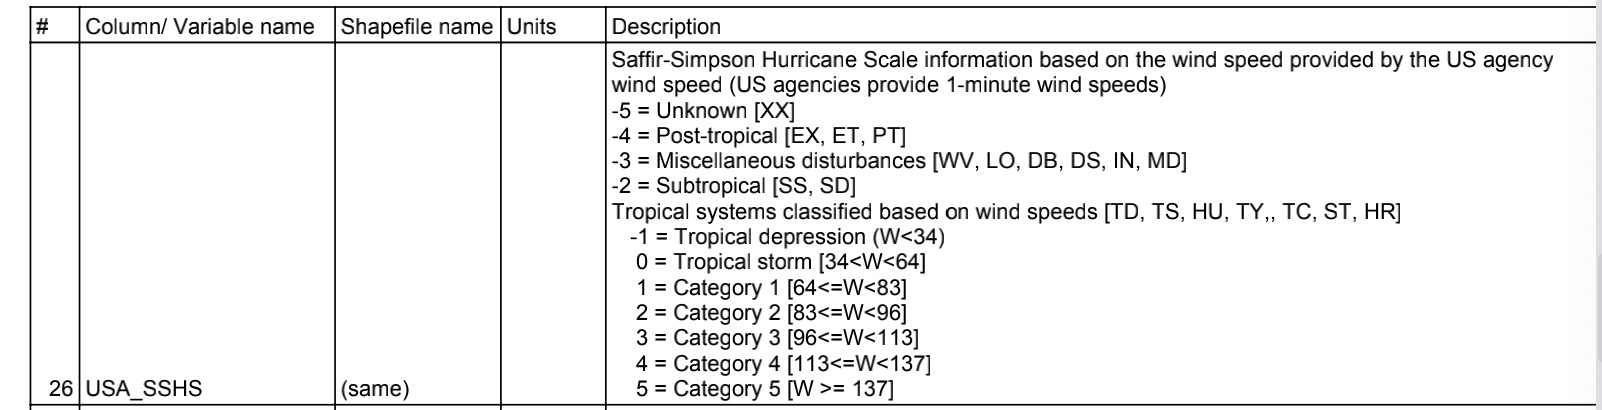

I (George), changed this code to only get min/mean/max landfall windspeed, lats and lons of the initial landing point, and the windspeed upon landfall. I also neglected the population data (too variable over time, not enough for rigorous analysis)

In [ ]:
def pos(lst):
    return [x for x in lst if x >= 0] or None

# function to gain the windspeed of landfall
def get_windspeed_landfall(storm):
  wind_speed = pos(storm.usa_sshs.values[storm.dist2land.values==0])
  if wind_speed != None:
     return  np.min(wind_speed),np.mean(wind_speed),np.max(wind_speed)
  else:
    return 0,0,0


# function to get the month for landfall
def get_month_landfall(storm):
  month = 0
  if len(storm.iso_time.values[storm.dist2land.values==0])>0:
    date = storm.iso_time.values[storm.dist2land.values==0][0]
    month = int(date[5:7])
  return month

def get_data_of_initial_landing(storm):
  # Returns lat,lon, windspeed of landing location
  lat_landfall = 0
  lon_landfall = 0
  init_windspeed = 0
  if len(storm.lat.values[storm.dist2land.values==0])>0:
    lat_landfall = storm.lat.values[storm.dist2land.values==0][0]
    lon_landfall = storm.lon.values[storm.dist2land.values==0][0]
    if storm.usa_sshs.values[storm.dist2land.values==0][0] > 0:
      init_windspeed = storm.usa_sshs.values[storm.dist2land.values==0][0]
  return lat_landfall, lon_landfall, init_windspeed

min_speed_land=[]
mean_speed_land=[]
max_speed_land=[]
lat_landfall = []
lon_landfall = []
init_windspeed = []
month = []

for i in tks.storm:
  storm = tks.sel(storm=i)
  min_wind, mean_wind, max_wind = get_windspeed_landfall(storm)
  min_speed_land.append(min_wind)
  mean_speed_land.append(mean_wind)
  max_speed_land.append(max_wind)

  lat, lon, spd = get_data_of_initial_landing(storm)
  lat_landfall.append(lat)
  lon_landfall.append(lon)
  init_windspeed.append(spd)
  month.append(get_month_landfall(storm))


min_speed_land = xr.DataArray(min_speed_land,dims='storm',coords={'storm':tks.storm})
mean_speed_land = xr.DataArray(mean_speed_land,dims='storm',coords={'storm':tks.storm})
max_speed_land = xr.DataArray(max_speed_land,dims='storm',coords={'storm':tks.storm})

lat_landfall = xr.DataArray(lat_landfall,dims='storm',coords={'storm':tks.storm})
lon_landfall = xr.DataArray(lon_landfall,dims='storm',coords={'storm':tks.storm})
init_windspeed = xr.DataArray(init_windspeed,dims='storm',coords={'storm':tks.storm})
month = xr.DataArray(month,dims='storm',coords={'storm':tks.storm})

tks_haoyue_george = tks_george.assign(min_speed_land = min_speed_land,mean_speed_land=mean_speed_land,max_speed_land=max_speed_land,
                                      lat_landfall=lat_landfall,lon_landfall=lon_landfall,init_windspeed=init_windspeed,month=month)



Reduce tks to something more manageable

In [ ]:
tks_analysis = tks_haoyue_george[['dist_on_land','travel_times','min_speed_land','mean_speed_land',
                                       'max_speed_land','lat_landfall','lon_landfall','init_windspeed',
                                       'season','numobs','number','name','sid','month']]

This doesn't do anything useful yet, might not ever be that useful since using season seems to be fine

In [ ]:
import pandas as pd
year_datetime = pd.to_datetime(tks_analysis.season.values,format='%Y')
year_datetime = xr.DataArray(year_datetime,dims='storm',coords={'storm':tks.storm})
tks_analysis = tks_analysis.assign(year_datetime=year_datetime)
tks_analysis = tks_analysis.set_coords('year_datetime')

Here is what the data looks like

In [ ]:
tks_analysis

<xarray.Dataset>
Dimensions:          (storm: 2293)
Coordinates:
  * storm            (storm) int64 0 1 2 3 4 5 ... 2287 2288 2289 2290 2291 2292
    year_datetime    (storm) datetime64[ns] 1851-01-01 1851-01-01 ... 2021-01-01
Data variables: (12/14)
    dist_on_land     (storm) float64 514.2 432.7 0.0 0.0 ... 0.0 0.0 125.8 66.46
    travel_times     (storm) float64 2.0 1.375 0.0 0.0 ... 0.0 0.0 0.25 0.125
    min_speed_land   (storm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mean_speed_land  (storm) float64 0.1176 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    max_speed_land   (storm) float64 1.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lat_landfall     (storm) float64 28.17 19.8 0.0 0.0 ... 0.0 0.0 31.3 9.88
    ...               ...
    season           (storm) float32 1.851e+03 1.851e+03 ... 2.021e+03 2.021e+03
    numobs           (storm) float32 37.0 41.0 1.0 1.0 ... 21.0 45.0 109.0 71.0
    number           (storm) int16 5 6 7 8 9 10 11 12 ... 74 75 76 80 81 88 90
    name             (storm) |S128 b'NOT_NAMED' b'NOT_NAMED' ... b'TERRY'
    sid              (storm) |S13 b'1851175N26270' ... b'2021306N10279'
    month            (storm) int64 6 6 0 0 0 8 0 9 0 9 ... 9 9 9 0 0 9 0 0 10 11
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

TODO: I HAVE ONLY FILTERED THE DATA TO RESTRICTING ONLY HURRICANES THAT TOUCHED LAND. ALSO, I HAVENT NORMALIZED ANYTHING YET 

In [ ]:
# Filter hurricanes and normalize
tks_onland = tks_analysis.where(tks_analysis.dist_on_land>0,drop=True)
tks_onland 

<xarray.Dataset>
Dimensions:          (storm: 1070)
Coordinates:
  * storm            (storm) int64 0 1 5 7 9 14 ... 2284 2285 2288 2291 2292
    year_datetime    (storm) datetime64[ns] 1851-01-01 1851-01-01 ... 2021-01-01
Data variables: (12/14)
    dist_on_land     (storm) float64 514.2 432.7 2.158e+03 ... 178.5 125.8 66.46
    travel_times     (storm) float64 2.0 1.375 3.125 0.25 ... 0.25 0.25 0.125
    min_speed_land   (storm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mean_speed_land  (storm) float64 0.1176 0.0 0.5172 0.0 ... 0.0 0.0 0.0 0.0
    max_speed_land   (storm) float64 1.0 0.0 2.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    lat_landfall     (storm) float64 28.17 19.8 18.53 22.1 ... 10.3 31.3 9.88
    ...               ...
    season           (storm) float32 1.851e+03 1.851e+03 ... 2.021e+03 2.021e+03
    numobs           (storm) float32 37.0 41.0 99.0 17.0 ... 131.0 109.0 71.0
    number           (storm) float64 5.0 6.0 10.0 12.0 ... 73.0 76.0 88.0 90.0
    name             (storm) object b'NOT_NAMED' b'NOT_NAMED' ... b'TERRY'
    sid              (storm) object b'1851175N26270' ... b'2021306N10279'
    month            (storm) float64 6.0 6.0 8.0 9.0 9.0 ... 9.0 9.0 10.0 11.0
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

TODO: HAVE A MORE RIGOROUS MEANS OF DETERMINING WEIGHTS FOR THIS CLUSTERING. Right now i am just taking the lats and lons of landfall, the initial windspeeds, the travel times as they are to cluster around. Not sure what it means

In [ ]:
# Let's do an arbitrary grouping to cluster by
def get_vars(storm):
  return[storm.lat_landfall.values,storm.lon_landfall.values,storm.init_windspeed.values,storm.travel_times,storm.dist_on_land,storm.month]
var_list =  [get_vars(tks_onland.sel(storm=i)) for i in tks_onland.storm
              if get_vars(tks_onland.sel(storm=i))]

This is the actual clustering bit. we see 3-4 clusters is probs best

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

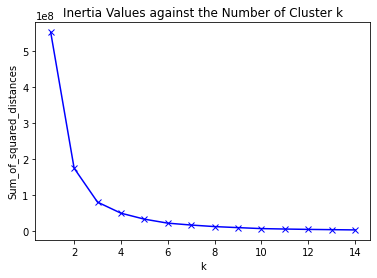

In [ ]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(var_list, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Pick 3 clusters, do the clusters. tks_clustered is the dataset with a variable for cluster

In [ ]:
n_clusters=3
km = k_means(var_list, n_clusters=n_clusters)
labels = km[1]
labels = xr.DataArray(labels,dims='storm',coords={'storm':tks_onland.storm})

tks_clustered = tks_onland.assign(labels=labels)
tks_clustered

<xarray.Dataset>
Dimensions:          (storm: 1070)
Coordinates:
  * storm            (storm) int64 0 1 5 7 9 14 ... 2284 2285 2288 2291 2292
    year_datetime    (storm) datetime64[ns] 1851-01-01 1851-01-01 ... 2021-01-01
Data variables: (12/15)
    dist_on_land     (storm) float64 514.2 432.7 2.158e+03 ... 178.5 125.8 66.46
    travel_times     (storm) float64 2.0 1.375 3.125 0.25 ... 0.25 0.25 0.125
    min_speed_land   (storm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mean_speed_land  (storm) float64 0.1176 0.0 0.5172 0.0 ... 0.0 0.0 0.0 0.0
    max_speed_land   (storm) float64 1.0 0.0 2.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    lat_landfall     (storm) float64 28.17 19.8 18.53 22.1 ... 10.3 31.3 9.88
    ...               ...
    numobs           (storm) float32 37.0 41.0 99.0 17.0 ... 131.0 109.0 71.0
    number           (storm) float64 5.0 6.0 10.0 12.0 ... 73.0 76.0 88.0 90.0
    name             (storm) object b'NOT_NAMED' b'NOT_NAMED' ... b'TERRY'
    sid              (storm) object b'1851175N26270' ... b'2021306N10279'
    month            (storm) float64 6.0 6.0 8.0 9.0 9.0 ... 9.0 9.0 10.0 11.0
    labels           (storm) int32 0 0 1 0 0 0 2 0 0 0 0 ... 0 0 1 0 2 2 0 0 0 0
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

Plotting the landfall locations for each cluster. The circles are for non-huriccanes to cat 2 and increase with windspeed. The triangle (3 sides), square (4 sides), and star (5 points) correspond with cats 3-5 respectively. They also increase in size given speed.

Text(0.5, 1.0, 'K-means clustering result')

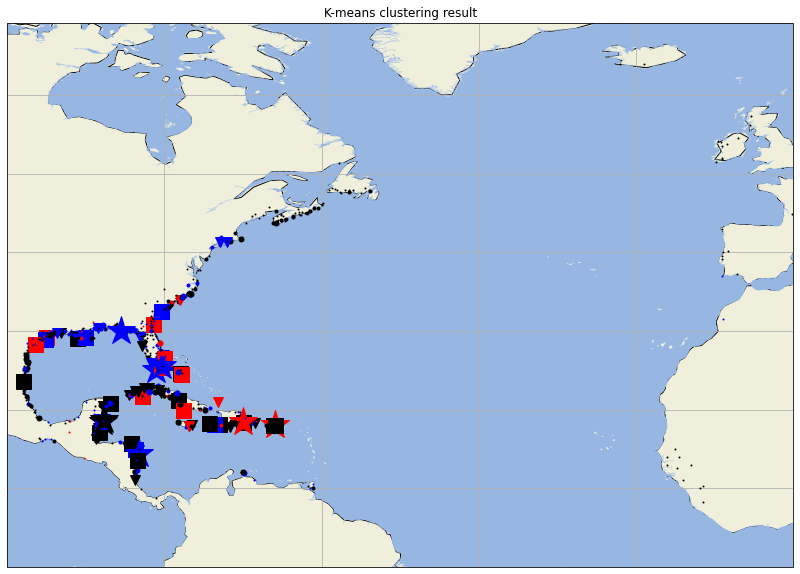

In [ ]:
# Look at landfall locations
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                      edgecolor='face', 
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face', 
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax
ax = map_background()

colors = ['black', 'red', 'blue', 'yellow','green']
markers = ['o','o','o','v','s','*']
sizes = [1,3,5,10,15,30]
for stormnum in tks_clustered.storm:
  storm = tks_clustered.sel(storm=stormnum)
  ax.plot(storm.lon_landfall, storm.lat_landfall, c=colors[storm.labels.values], 
        marker=markers[int(storm.init_windspeed.values)],markersize=sizes[int(storm.init_windspeed.values)])
plt.title('K-means clustering result')

Now some initial analysis of the clustors. We can see some clusters might be more dangerous than the others

In [ ]:
for label in range(n_clusters):
  temp = tks_clustered.where(tks_clustered.labels==label,drop=True)
  print(f'Looking at cluster {label}')
  print(f"The number of landfall storms is {len(temp.storm)}")
  print(f"The median category at landfall is {float(np.median(temp.init_windspeed))}")
  print(f"The median category while on land is {float(np.median(temp.mean_speed_land))}")
  print(f"The median duration while on land is {float(np.median(temp.travel_times))} days")
  print(f"The median distance travelled while on land is {float(np.median(temp.dist_on_land))} km\n")
  print(f"The mean category at landfall is {float(np.mean(temp.init_windspeed))}")
  print(f"The mean category while on land is {float(np.mean(temp.mean_speed_land))}")
  print(f"The mean duration while on land is {float(np.mean(temp.travel_times))} days")
  print(f"The mean distance travelled while on land is {float(np.mean(temp.dist_on_land))} km\n")

Looking at cluster 0
The number of landfall storms is 760
The median category at landfall is 0.0
The median category while on land is 0.0
The median duration while on land is 0.5 days
The median distance travelled while on land is 225.71999857976977 km

The mean category at landfall is 0.4052631578947368
The mean category while on land is 0.22677412680105158
The mean duration while on land is 0.6805235745464941 days
The mean distance travelled while on land is 276.36697517847216 km

Looking at cluster 1
The number of landfall storms is 67
The median category at landfall is 1.0
The median category while on land is 0.30000001192092896
The median duration while on land is 3.5833333334885538 days
The median distance travelled while on land is 2598.367667142493 km

The mean category at landfall is 1.3432835820895523
The mean category while on land is 0.49716262374796083
The mean duration while on land is 3.893190298451861 days
The mean distance travelled while on land is 2737.930035945494 k

Now, to validate this hunch, let's compare this with the costliest hurricanes between 1950-2018. This data is from the supplementary table from Weinkle, J., Landsea, C., Collins, D. et al. Normalized hurricane damage in the continental United States 1900–2017. Nat Sustain 1, 808–813 (2018). https://doi.org/10.1038/s41893-018-0165-2

The data was cleaned up a bit in excel and uploaded into the notebook. 

TODO: Upload it directly from the shared drive folder

In [ ]:
damage_data = pd.read_csv('data/damage_data.csv')
damage_data

,Year,Storm ID,Storm Name,Category,State,BASE,PL2018,CL2018
0,1950,1950_Baker,Baker,1,"AL,FL",NaN,668652013,646922296
1,1950,1950_Easy,Easy,3,FL,"3,300,000",2246898463,1867258674
2,1950,1950_King,King,4,FL,"28,000,000",6756169482,5823791982
3,1952,1952_Able,Able,2,SC,"2,800,000",202785723,297824240
4,1953,1953_Barbara,Barbara,1,NC,"1,000,000",68430295,126738996
...,...,...,...,...,...,...,...,...
98,2016,2016_Hermine,Hermine,1,FL,"400,000,000",430160568,427701995
99,2016,2016_Matthew,Matthew,1,"FL,GA,SC,NC","8,000,000,000",8556324420,8586318757
100,2017,2017_Harvey,Harvey,4,TX,"60,000,000,000",62191097565,62123671136
101,2017,2017_Irma,Irma,4,FL,"30,000,000,000",30972463481,31000171418


We do some processing to pull the cluster labels from our xarray dataset by searching for hurricane name and year

In [ ]:
labels_for_damage = []
for i in range(len(damage_data)):
  name = damage_data['Storm Name'][i].upper().encode('ascii')
  year = int(damage_data['Year'][i])
  filt_name = tks_clustered.where(tks_clustered.name==name,drop=True)
  filt_year = filt_name.where(tks_clustered.season==year,drop=True)
  if len(filt_year.storm) == 1:
    labels_for_damage.append(int(filt_year.labels.values))
  else:
    labels_for_damage.append(-1)

In [ ]:
damage_data['label'] = labels_for_damage

Now, we see the average damage per label. 

In [ ]:
for i in range(n_clusters):
  temp = damage_data[damage_data['label']==i]
  mean_damage = np.mean(temp["CL2018"])/1e9
  std = np.std(temp["CL2018"])/1e9
  median = np.median(temp["CL2018"])/1e9
  print(f"For cluster {i}")
  print(f"The average normalized (2018) damage is about ${mean_damage} ± {std} billion USD")
  print(f"The median normalized (2018) damage is about ${median} billion USD")
  print(f"The count of hurricanes in the damage dataset is {len(temp)}")
  print(f"The percentage of hurricanes out of the total cluster is {100*len(temp)/len(tks_clustered.where(tks_clustered.labels==0,drop=True).storm)}")

For cluster 0
The average normalized (2018) damage is about $5.839928478 ± 14.47315274760181 billion USD
The median normalized (2018) damage is about $0.6193764245 billion USD
The count of hurricanes in the damage dataset is 30
The percentage of hurricanes out of the total cluster is 3.9473684210526314
For cluster 1
The average normalized (2018) damage is about $13.884418238866667 ± 14.132327236949402 billion USD
The median normalized (2018) damage is about $11.192070812 billion USD
The count of hurricanes in the damage dataset is 15
The percentage of hurricanes out of the total cluster is 1.9736842105263157
For cluster 2
The average normalized (2018) damage is about $12.616818690907408 ± 23.327281308849475 billion USD
The median normalized (2018) damage is about $4.3850470475 billion USD
The count of hurricanes in the damage dataset is 54
The percentage of hurricanes out of the total cluster is 7.105263157894737


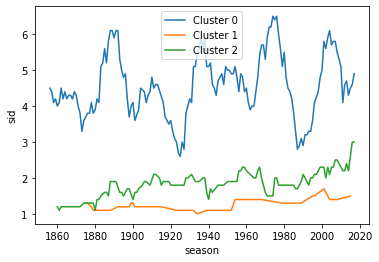

In [ ]:
#@title
# Plot counts of clusters over time
for label in range(n_clusters):
  temp = tks_clustered.where(tks_clustered.labels==label,drop=True)
  counts = temp.groupby('season').count()
  counts.sid.rolling(season=10, center=True).mean().plot(label=f"Cluster {label}")
plt.legend()


In [ ]:
len(tks_clustered.where(tks_clustered.labels==0,drop=True).storm)

762